# TITANIC DATASET ANALYSIS

#### Import necessary libraries

In [104]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier




#### Load the dataset into a dataframe

In [105]:
data = pd.read_csv('titanic.csv')
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.00,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.00,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.00,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.00,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


#### Data description

We can use the `describe()` method to get a summary of the numerical attributes of the dataset. This will help us to understand the data better.

In [106]:
data.describe()

,pclass,survived,age,sibsp,parch,fare,body
count,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,121.000000
mean,2.294882,0.381971,29.881138,0.498854,0.385027,33.295479,160.809917
std,0.837836,0.486055,14.413493,1.041658,0.865560,51.758668,97.696922
min,1.000000,0.000000,0.170000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,21.000000,0.000000,0.000000,7.895800,72.000000
50%,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200,155.000000
75%,3.000000,1.000000,39.000000,1.000000,0.000000,31.275000,256.000000
max,3.000000,1.000000,80.000000,8.000000,9.000000,512.329200,328.000000


The `info()` method will give us a concise summary of the dataframe, including the number of non-null values in each column as well as the data type of each column.

In [107]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     1309 non-null   int64  
 1   survived   1309 non-null   int64  
 2   name       1309 non-null   object 
 3   sex        1309 non-null   object 
 4   age        1046 non-null   float64
 5   sibsp      1309 non-null   int64  
 6   parch      1309 non-null   int64  
 7   ticket     1309 non-null   object 
 8   fare       1308 non-null   float64
 9   cabin      295 non-null    object 
 10  embarked   1307 non-null   object 
 11  boat       486 non-null    object 
 12  body       121 non-null    float64
 13  home.dest  745 non-null    object 
dtypes: float64(3), int64(4), object(7)
memory usage: 143.3+ KB


In order to understand what features we may have to clean, as there might be missing values, we can use the code below to get the percentage of NaN values in each column.

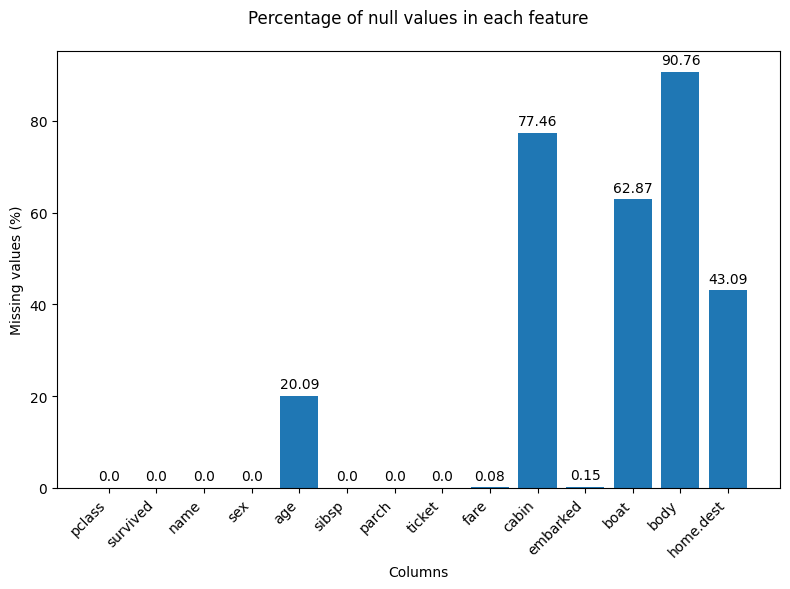

In [108]:
# Calculate the percentage of missing values in each column
missing_data = data.isna().sum() / len(data) * 100

# Create a bar graph
plt.figure(figsize=(8, 6))
bars = plt.bar(missing_data.index, missing_data.values)
plt.title('Percentage of null values in each feature', pad=20)
plt.xlabel('Columns')
plt.ylabel('Missing values (%)')

plt.xticks(rotation=45, ha='right')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, round(yval, 2), ha='center', va='bottom')

plt.tight_layout()
plt.show()

##### NaN values
Upon reviewing the dataset, we noted a significant number of NaN values in the `body`, `boat`, and `cabin` columns. Given their high percentage of NaN values, we decided to drop these columns as they wouldn't contribute meaningfully to our analysis. Although the `age`, `home.dest`, `embarked` and `fare` columns also contained some missing data, falling under 50%, we needed to think how we would handle them. We resolved to drop the `home.dest` column due to its limited relevance to our analysis. For the `age` and `fare` columns, we chose to turn the NaN values into the mean of the column and for the `embarked`column we decided to populate those NaN values with the most frequent value in the column.

##### Data cleaning
After addressing the features with a significat percentage of NaN values, we turned our attention to the other columns. Upon consideration, we determined that the `name` column served no significant purpose for our analysis decideding to drop it. Similarly, we chose to remove the `ticket` column as it merely serves as a unique identifier for each passenger and does not offer valuable insights. Additionally, recognizing the presence of categorical features, we proceeded to convert them into numerical values using the `get_dummies()` method. Specifically, the `sex` and `embarked` columns were converted into multiple boolean columns. For the `sex` column, it created two new columns: `sex_male` and `sex_female`, where a `true` represents the presence of that category and a `false` represents the absence. Similarly, for the `embarked` column, it created three new columns: `embarked_C`, `embarked_Q`, and `embarked_S`, each representing one of the original categories.

In [109]:
# Changing the Nan values in the age, fare and embarked columns to the mean of the column
data.fillna({'age': data['age'].mean(), 'fare': data['fare'].mean(), 'embarked': data['embarked'].mode()[0]}, inplace=True)

# Dropping the body, boat, cabin and home.dest columns
processed_data = data.drop([
    'boat', 
    'body', 
    'cabin', 
    'home.dest',
    'name',
    'ticket'
], axis=1) 


processed_data = pd.get_dummies(processed_data)
processed_data.head()


,pclass,survived,age,sibsp,parch,fare,sex_female,sex_male,embarked_C,embarked_Q,embarked_S
0,1,1,29.00,0,0,211.3375,True,False,False,False,True
1,1,1,0.92,1,2,151.5500,False,True,False,False,True
2,1,0,2.00,1,2,151.5500,True,False,False,False,True
3,1,0,30.00,1,2,151.5500,False,True,False,False,True
4,1,0,25.00,1,2,151.5500,True,False,False,False,True


Although the dataset was basically clean, we still made some changes. We needed to drop one of `sex_male` and `sex_female` columns to avoid multicollinearity as they are inversely related and we also decided to merge `sibsp` and `parch` columns into a single column called `family` that represents the number of family members on board. Similarly, with the `sex_male` and `sex_female` columns, we dropped one of the `embarked_C`, `embarked_Q`, and `embarked_S` columns to avoid multicollinearity.

In [110]:
processed_data['family'] = processed_data['sibsp'] + processed_data['parch']

processed_data = processed_data.drop([
    'sex_male',
    'sibsp',
    'parch',
    'embarked_C'
], axis=1)


processed_data.head()


,pclass,survived,age,fare,sex_female,embarked_Q,embarked_S,family
0,1,1,29.00,211.3375,True,False,True,0
1,1,1,0.92,151.5500,False,False,True,3
2,1,0,2.00,151.5500,True,False,True,3
3,1,0,30.00,151.5500,False,False,True,3
4,1,0,25.00,151.5500,True,False,True,3


So in order to understand how those features are related to the survival rate, we ploted a graph to show how the features are distributaded based on the survival rate.

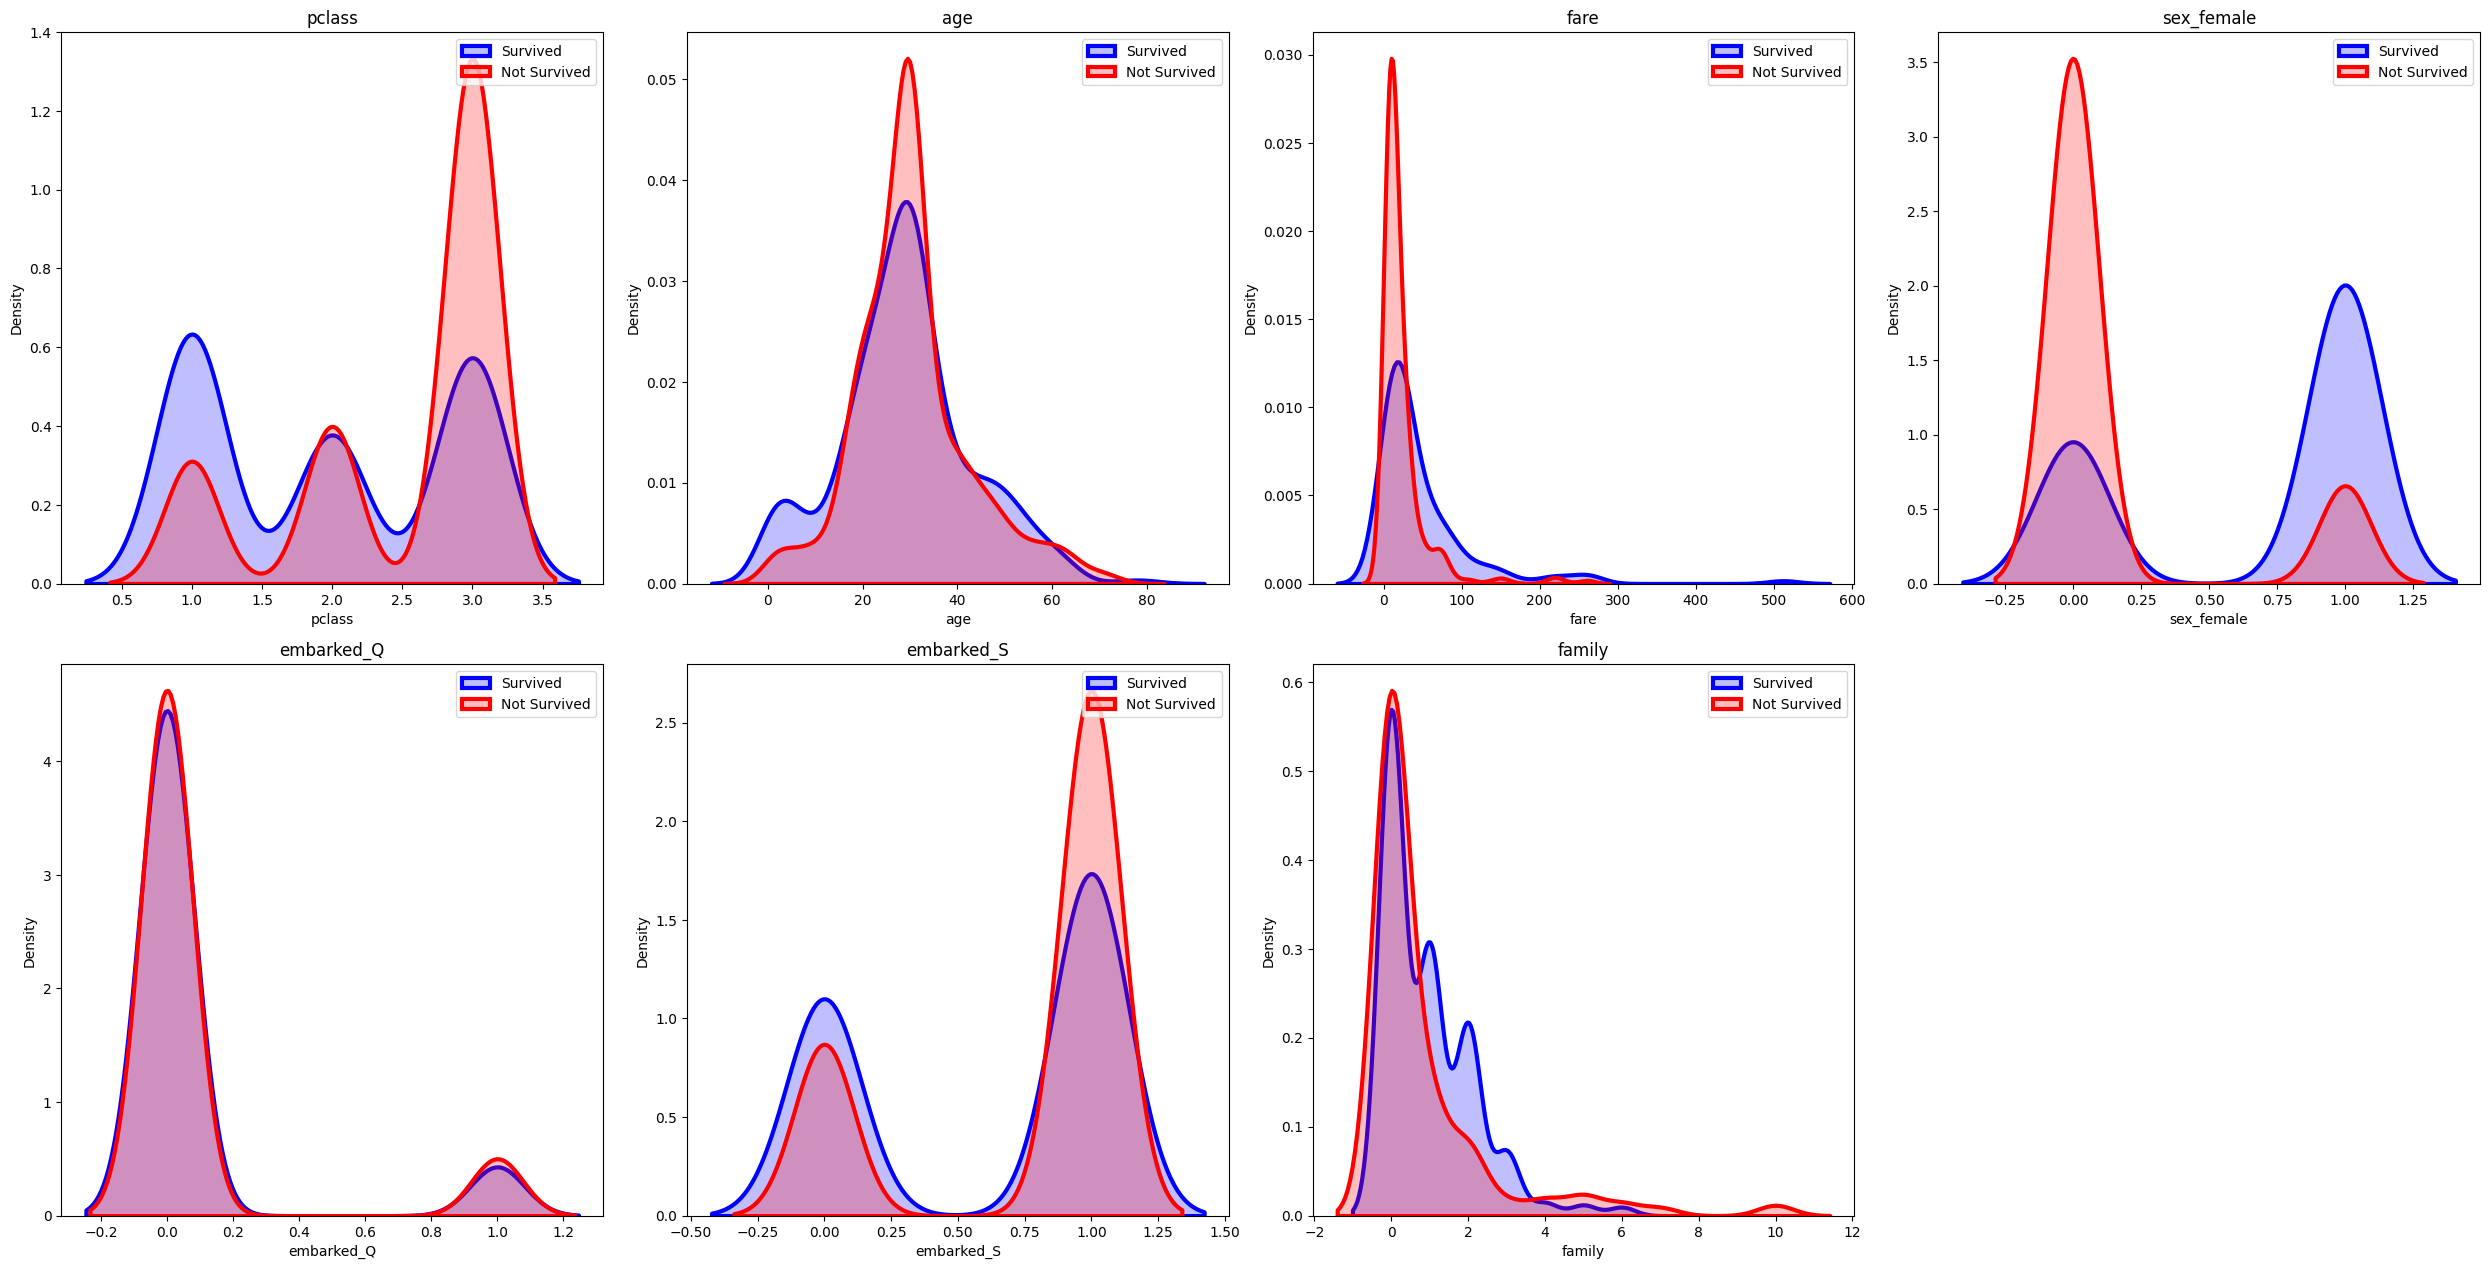

In [111]:
plt.figure(figsize=(25,25))
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

# Create dataframes for survived and not survived
pd1 = processed_data[processed_data['survived']==1].drop(['survived'],axis=1)
pd2 = processed_data[processed_data['survived']==0].drop(['survived'],axis=1)

for i, col in enumerate(list(pd1.columns)):
    plt.subplot(4, 4, i+1)
    
    # Use seaborn kdeplot which allows you to draw a line at the mean
    sb.kdeplot(pd1[col], fill=True, linewidth=3, color='blue', label='Survived')
    sb.kdeplot(pd2[col], fill=True, linewidth=3, color='red', label='Not Survived')
    
    plt.legend(prop={'size': 10})
    plt.title(col)

plt.tight_layout()
plt.show()

Now to verify numerically the correlation between the features and the survival rate, we used the `corr()` method to calculate the correlation between the features and the target variable. We then plotted a heatmap to visualize the correlation between the features and the target variable.

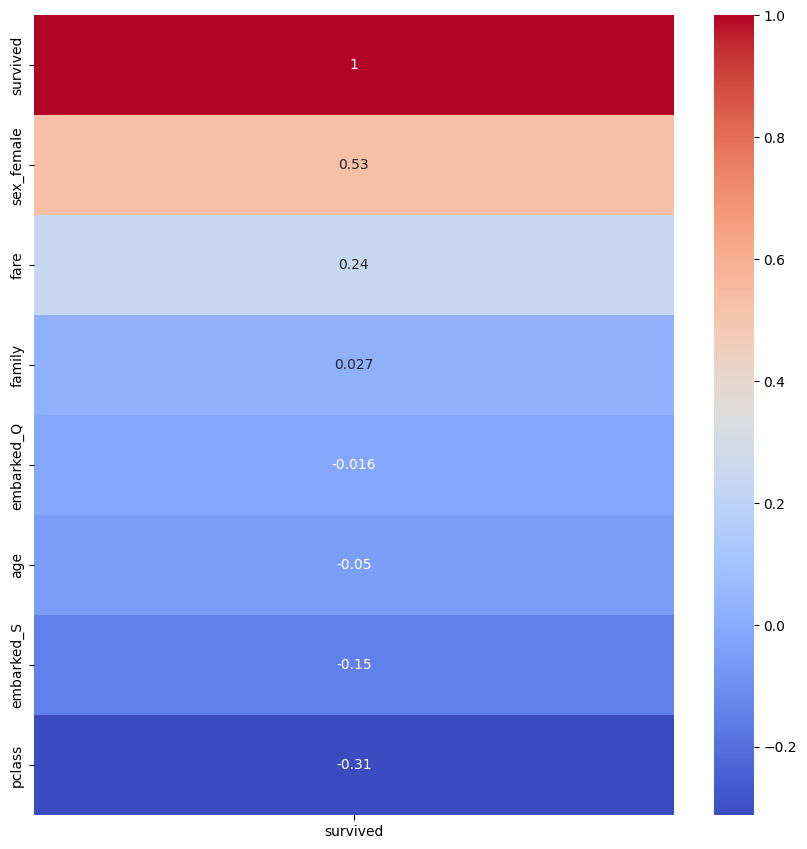

In [112]:
cols = list(processed_data.columns)
plt.figure(figsize=(10,10))
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

corr = processed_data.corr()[['survived']].sort_values(by='survived', ascending=False)
sb.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

The heatmap made above show the correlation, numerically, between the features and the target variable. A positive value indicates that when the feature increases, the target variable also increases. A negative value indicates that when the feature increases, the target variable decreases. A value of 0 indicates no correlation between the feature and the target variable.

#### Data analysis

In [113]:
# Splitting the data into features and target
X = processed_data.drop('survived', axis=1)
y = processed_data['survived']

##### Train-test split



In [114]:
unique, counts = np.unique(y, return_counts=True)
result = dict(zip(unique, counts))
print(result)

{0: 809, 1: 500}


Considering our dataset is quiet unbalanced we needed to split the data in a way that the distribution of the target variable is the same in both the training and testing sets. For that we used the `train_test_split()` method from the `sklearn.model_selection` module to split the data into 80% training and 20% testing sets. This allowed us to train our model on the training set and evaluate its performance on the testing set. We defined `random_state = 42` to ensure reproducibility of the results and have defined a stratify parameter to ensure that the distribution of the target variable is the same in both the training and testing sets as mentioned before.

In [115]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In order to evaluate how well our model performs, we used the `accuracy_score()` method from the `sklearn.metrics` module. This method calculates the accuracy of the model by comparing the predicted values with the actual values in the testing set.

##### Logistic regression

`Logistic regression` stands as a supervised learning algorithm within machine learning. It excels in classification tasks, particularly those with binary outcomes. The model functions by establishing a linear decision boundary within the feature space. This boundary effectively separates the two target categories, allowing for the classification of new data points based on their relative position. It calculates the probability of an instance belonging to a specific class. This probability is then translated into a binary classification through a predefined threshold. Data points with probabilities exceeding the threshold are assigned to the first class, while those falling below are classified into the second.

In [116]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.8206106870229007


##### Decision Tree

`Decision Trees` function as a supervised learning methodology adept at classification tasks. These algorithms present a tree-like structure, where internal nodes represent decision points based on specific features of the data. At each node, a question is posed, directing the data point down a binary path ("yes" or " "no") based on its attribute values. This iterative process of inquiry continues until the data point reaches a terminal node, also known as a leaf node, signifying its assigned classification.

In [117]:
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')


Accuracy: 0.7709923664122137


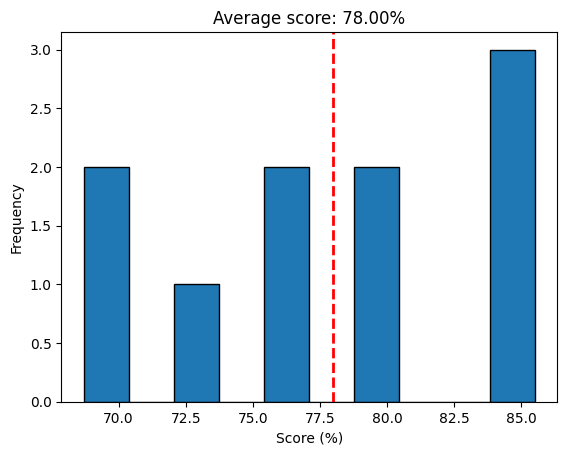

In [118]:
n_splits = 10

decision_tree_classifier = DecisionTreeClassifier(max_depth=1)

cv_scores = cross_val_score(decision_tree_classifier, X, y, cv=n_splits) * 100

average_score = np.mean(cv_scores)

# Create a histogram of the cross-validation scores
plt.hist(cv_scores, edgecolor='black')
plt.title(f'Average score: {average_score:.2f}%')
plt.xlabel('Score (%)')
plt.ylabel('Frequency')
plt.axvline(average_score, color='r', linestyle='dashed', linewidth=2)  # Add a vertical line at the average score
plt.show()

In [119]:

from sklearn.model_selection import GridSearchCV

decision_tree_classifier = DecisionTreeClassifier()

parameter_grid = {'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], 
                  'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9]}

cross_validation = StratifiedKFold(n_splits=10)

grid_search = GridSearchCV( decision_tree_classifier, param_grid=parameter_grid, cv=cross_validation)

grid_search.fit(X, y)

print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))


grid_visualization = grid_search.cv_results_['mean_test_score']
grid_visualization.shape = (20, 9)
sb.heatmap(grid_visualization, cmap='Blues', annot=True)
plt.xticks(np.arange(9) + 0.5, grid_search.param_grid['max_features'])
plt.yticks(np.arange(20) + 0.5, grid_search.param_grid['max_depth'])
plt.xlabel('max_features')
plt.ylabel('max_depth')

##### Random Forest

A `Random Forest` is a machine learning algorithm that operates by constructing multiple decision trees during training and outputting the class that is the mode of the classes output by individual trees.

In [ ]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.7786259541984732


##### Extra Trees

`Extra Trees` is a type of learning technique that is fundamentally similar to a Random Forest. However, it introduces additional randomness in the construction of the decision trees, which often results in slightly higher bias and lower variance compared to a Random Forest.

In [ ]:
model = ExtraTreesClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.7709923664122137


##### MLP

`MLP` stands for Multi-Layer Perceptron, which is a type of neural network. It's composed of multiple layers of nodes, each connected to the next. The first layer takes in input, the last layer produces output, and any layers in between are known as hidden layers.

In [ ]:
model = MLPClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.8244274809160306


##### K-Nearest Neighbors

`K-Nearest Neighbors` is a type of instance-based learning, or lazy learning, where the function is only approximated locally and all computation is deferred until function evaluation. The KNN algorithm assumes that similar things exist in close proximity. In other words, similar things are near to each other.

In [ ]:
model = KNeighborsClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.6793893129770993


##### Quadratic Discriminant Analysis

`Quadratic Discriminant Analysis` is a classification algorithm that is closely related to Linear Discriminant Analysis. However, where LDA assumes that the observations within each class are drawn from a multivariate Gaussian distribution with a shared covariance matrix, QDA assumes that each class has its own covariance matrix.

In [ ]:
model = QuadraticDiscriminantAnalysis()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.7786259541984732


##### SVM

`Support Vector Machines` are a type of supervised learning algorithm that can be used for both classification and regression challenges. However, it is mostly used in classification problems. In the SVM algorithm, we plot each data item as a point in n-dimensional space (where n is the number of features you have) with the value of each feature being the value of a particular coordinate. Then, we perform classification by finding the hyper-plane that differentiates the two classes very well.

In [ ]:
model = SVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.6641221374045801


##### Naive Bayes

`Naive Bayes` is a classification technique based on Bayes' Theorem with an assumption of independence among predictors. In simple terms, a Naive Bayes classifier assumes that the presence of a particular feature in a class is unrelated to the presence of any other feature.

In [ ]:
model = GaussianNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.7938931297709924


##### Gradient Boosting

`Gradient Boosting` is a machine learning technique for regression and classification problems, which produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees. It builds the model in a stage-wise fashion like other boosting methods do, and it generalizes them by allowing optimization of an arbitrary differentiable loss function.

In [ ]:
model = GradientBoostingClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.8129770992366412


##### CatBoost

`CatBoost` is a machine learning algorithm that uses gradient boosting on decision trees.

In [ ]:
model = CatBoostClassifier(logging_level='Silent')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.8473282442748091
